# GloVE

Let's work on implementation of GloVE.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## 1. Define some very simple data for understanding

In [2]:
corpus = ["apple banana fruit", "banana apple fruit", "banana fruit apple",
                 "dog cat animal", "cat animal dog", "cat dog animal"]

In [3]:
corpus = [sent.split(" ") for sent in corpus]
corpus

[['apple', 'banana', 'fruit'],
 ['banana', 'apple', 'fruit'],
 ['banana', 'fruit', 'apple'],
 ['dog', 'cat', 'animal'],
 ['cat', 'animal', 'dog'],
 ['cat', 'dog', 'animal']]

In [4]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))
vocab

['animal', 'cat', 'dog', 'banana', 'fruit', 'apple']

In [5]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}
print(word2index)

{'animal': 0, 'cat': 1, 'dog': 2, 'banana': 3, 'fruit': 4, 'apple': 5}


In [6]:
#vocab size
voc_size = len(vocab)
print(voc_size)

6


In [7]:
#append UNK
vocab.append('<UNK>')

In [8]:
vocab

['animal', 'cat', 'dog', 'banana', 'fruit', 'apple', '<UNK>']

In [9]:
word2index['<UNK>'] = 0

In [10]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()} 

## 2. Build Co-occurence Matrix X

Here, we need to count the co-occurence of two words given some window size.  We gonna use window size of 1.

In [11]:
from collections import Counter

X_i = Counter(flatten(corpus)) # X_i
X_i

Counter({'apple': 3, 'banana': 3, 'fruit': 3, 'dog': 3, 'cat': 3, 'animal': 3})

In [12]:
# Make skip gram of one size window
skip_grams = []
# loop each word sequence
# we starts from 1 because 0 has no context
# we stop at second last for the same reason
for sent in corpus:
    for i in range(1, len(sent) - 1):
        target = sent[i]
        context = [sent[i - 1], sent[i + 1]]
        for w in context:
            skip_grams.append((target, w))

skip_grams

[('banana', 'apple'),
 ('banana', 'fruit'),
 ('apple', 'banana'),
 ('apple', 'fruit'),
 ('fruit', 'banana'),
 ('fruit', 'apple'),
 ('cat', 'dog'),
 ('cat', 'animal'),
 ('animal', 'cat'),
 ('animal', 'dog'),
 ('dog', 'cat'),
 ('dog', 'animal')]

In [13]:
X_ik_skipgram = Counter(skip_grams) # Co-occurece in window size 1
X_ik_skipgram

Counter({('banana', 'apple'): 1,
         ('banana', 'fruit'): 1,
         ('apple', 'banana'): 1,
         ('apple', 'fruit'): 1,
         ('fruit', 'banana'): 1,
         ('fruit', 'apple'): 1,
         ('cat', 'dog'): 1,
         ('cat', 'animal'): 1,
         ('animal', 'cat'): 1,
         ('animal', 'dog'): 1,
         ('dog', 'cat'): 1,
         ('dog', 'animal'): 1})

### Weighting function

GloVe includes a weighting function to scale down too frequent words.

<img src = "figures/glove_weighting_func.png" width=400>

In [14]:
#simply a normalized function...don't worry too much
def weighting(w_i, w_j, X_ik):
        
    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1
                
    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75
    
    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum
    
    return result

In [15]:
from itertools import combinations_with_replacement

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocab, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches 
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass
        
    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

print(f"{X_ik=}")
print(f"{weighting_dic=}")


X_ik={('animal', 'cat'): 2, ('cat', 'animal'): 2, ('animal', 'dog'): 2, ('dog', 'animal'): 2, ('cat', 'dog'): 2, ('dog', 'cat'): 2, ('banana', 'fruit'): 2, ('fruit', 'banana'): 2, ('banana', 'apple'): 2, ('apple', 'banana'): 2, ('fruit', 'apple'): 2, ('apple', 'fruit'): 2}
weighting_dic={('animal', 'animal'): 0.03162277660168379, ('animal', 'cat'): 0.053182958969449884, ('cat', 'animal'): 0.053182958969449884, ('animal', 'dog'): 0.053182958969449884, ('dog', 'animal'): 0.053182958969449884, ('animal', 'banana'): 0.03162277660168379, ('banana', 'animal'): 0.03162277660168379, ('animal', 'fruit'): 0.03162277660168379, ('fruit', 'animal'): 0.03162277660168379, ('animal', 'apple'): 0.03162277660168379, ('apple', 'animal'): 0.03162277660168379, ('animal', '<UNK>'): 0.03162277660168379, ('<UNK>', 'animal'): 0.03162277660168379, ('cat', 'cat'): 0.03162277660168379, ('cat', 'dog'): 0.053182958969449884, ('dog', 'cat'): 0.053182958969449884, ('cat', 'banana'): 0.03162277660168379, ('banana', 'c

## 3. Prepare train data

In [16]:
for c in corpus:
    print(c)

['apple', 'banana', 'fruit']
['banana', 'apple', 'fruit']
['banana', 'fruit', 'apple']
['dog', 'cat', 'animal']
['cat', 'animal', 'dog']
['cat', 'dog', 'animal']


In [17]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):
    
    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]
    
    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3
        
        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])
        
        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])
                    
    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

### Testing the method

In [18]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[0]
 [1]]
Target:  [[1]
 [2]]
Cooc:  [[0.69314718]
 [0.69314718]]
Weighting:  [[0.05318296]
 [0.05318296]]


## 4. Model

<img src ="figures/glove.png">

In [19]:
class GloVe(nn.Module):
    
    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding
        
        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)
        
    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        
        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)
        
        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]
        
        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)
        
        return torch.sum(loss)

## 5. Training

In [20]:
batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
model          = GloVe(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
import time

# Training
num_epochs = 5000
for epoch in range(num_epochs):
    
    start = time.time()
    
    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]
    
    optimizer.zero_grad()
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)
    
    loss.backward()
    optimizer.step()
    
    end = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 1000 | cost: 0.050733 | time: 0m 0s
Epoch: 2000 | cost: 0.000005 | time: 0m 0s
Epoch: 3000 | cost: 0.000000 | time: 0m 0s
Epoch: 4000 | cost: 0.000000 | time: 0m 0s
Epoch: 5000 | cost: 0.000000 | time: 0m 0s


## 6. Plotting the embeddings

In [23]:
#list of vocabs
vocab[:10]

['animal', 'cat', 'dog', 'banana', 'fruit', 'apple', '<UNK>']

In [24]:
word = vocab[0]

In [25]:
#numericalization
id = word2index[word]
id

0

In [26]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [27]:
#get the embedding by averaging
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[-0.4547,  0.0719]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.9237,  0.5004]], grad_fn=<EmbeddingBackward0>))

In [28]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(0.2861, grad_fn=<SelectBackward0>)

In [29]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

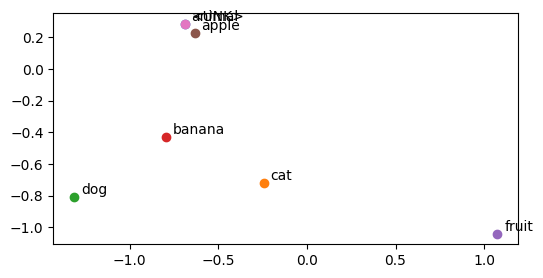

In [30]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$ 

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [31]:
vocab

['animal', 'cat', 'dog', 'banana', 'fruit', 'apple', '<UNK>']

In [32]:
#let's try similarity between first and second, and second and third
cat          = get_embed('cat')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

In [33]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim
    
print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  0.4297538348963393
cat vs. animal:  -0.06819172453918752
cat vs. cat:  1.0


In [34]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"cat vs. fruit: ",     cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  0.4297538348963392
cat vs. animal:  -0.06819172453918743
cat vs. cat:  1
